In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import re
from haversine import haversine, Unit
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Data pre-processing

In [2]:
dfTrain = pd.read_csv("prepared_data/apartments_and_building_train.csv")
dfTest = pd.read_csv("prepared_data/apartments_and_building_test.csv")

In [3]:
def get_distance_center(lat1, lon1):
    dist = haversine((lat1, lon1), (55.751244, 37.618423), unit=Unit.METERS)
    return round(dist/1000, 3)

def get_shortest_distance(lat, lon, coordinates):
    shortest = np.inf
    for coord in coordinates:
        dist = haversine(coord, (lat, lon), unit=Unit.METERS)
        if dist < shortest:
            shortest = dist
    if shortest == np.inf:
        return 100
    return round(shortest/1000, 3)

Distance to center

In [4]:
dfTrain["distance_center"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)
dfTest["distance_center"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance_center(x.latitude, x.longitude), axis=1)

Metro stations

In [5]:
def add_distance_to(target, df_train, df_test):
    targets = pd.read_csv(f"prepared_data/extra_features/{target}.csv")
    coordinates = targets.values.tolist()

    df_train[f"distance_{target}"] = df_train.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)
    df_test[f"distance_{target}"] = df_test.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)

""" positive """
add_distance_to("metro", dfTrain, dfTest)
add_distance_to("university", dfTrain, dfTest)
add_distance_to("shopping_center", dfTrain, dfTest)
add_distance_to("park", dfTrain, dfTest)
add_distance_to("golf_course", dfTrain, dfTest)
""" negative """
add_distance_to("airport", dfTrain, dfTest)
add_distance_to("prison", dfTrain, dfTest)

In [6]:
def process_data(dataframe, keep_col):
    """ columns = ['building_id', 'id_x', 'id_y', 'seller', 'price', 'area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 
            'condition', 'phones', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 
            'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'parking', 'garbage_chute', 'heating', 'distance_center', 'distance_metro',
            'distance_university', 'distance_shopping_center', 'distance_park', 'distance_golf_course', 
            'distance_airport', 'distance_prison'] """

    remove_columns = ['street', 'address', 'building_id', 'id_y', 'id_x', 'price']

    # 'distance_university', 'distance_shopping_center', 'distance_park', 'distance_golf_course', 'distance_airport', 'distance_prison'
   
    for col in keep_col:
        remove_columns.remove(col)

    dataframe = dataframe.drop(remove_columns, axis=1)
    
            
    """
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']
    for column in dataframe.columns.values:
        
        if(column in fill_mode):
            #print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
            
     fill_mean=['area_total', 'area_kitchen', 
            'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 
            'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'phones', 'new', 'latitude', 'longitude',
            'constructed', 'stories', 'elevator_without', 'elevator_passenger',
            'elevator_service', 'garbage_chute', 'distance_center', 'distance_metro']
    
    fill_mode=['seller', 'condition', 'district','material','heating', 'parking']

    for column in dataframe.columns.values:
        #Finding the mean of the column having NaN
        mean_value=dataframe[column].mean()
        dataframe[column].fillna(value=mean_value, inplace=True)
    
        if(column in fill_mean):
            print("Filling "+column+" with mean")
            mean_value=dataframe[column].mean()
            dataframe[column].fillna(value=mean_value, inplace=True)
            
        if(column in fill_mode):
            print("Filling "+column+" with mode")
            mode_value=dataframe[column].mode()
            dataframe[column].fillna(value=mode_value, inplace=True)
    """

    return dataframe

# LGBMRegression

<ipython-input-72-b449540e5e1b>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.13


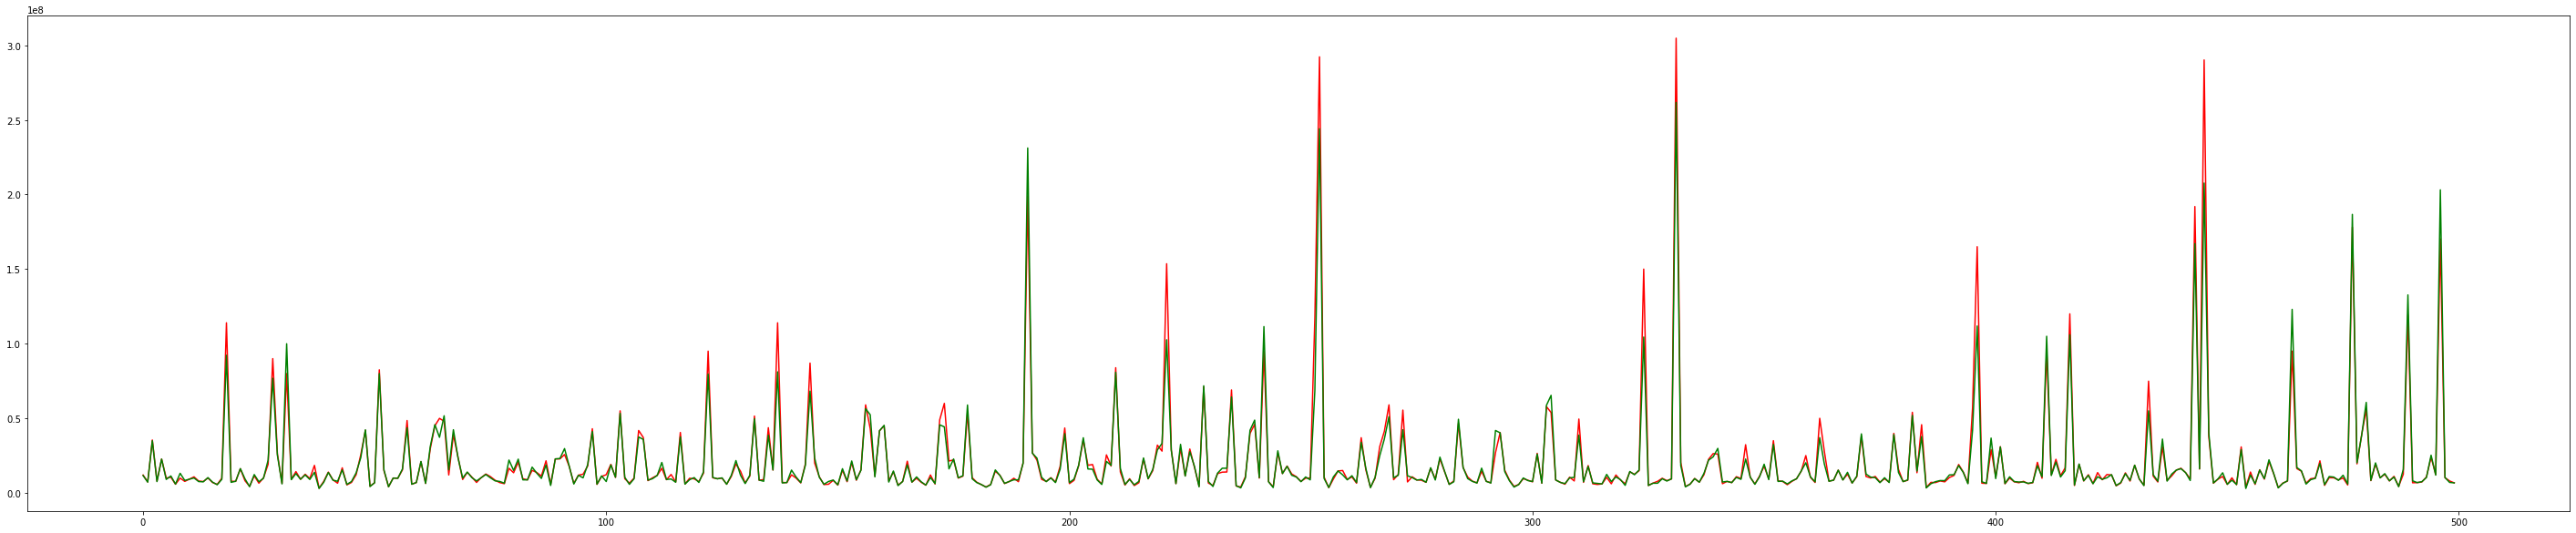

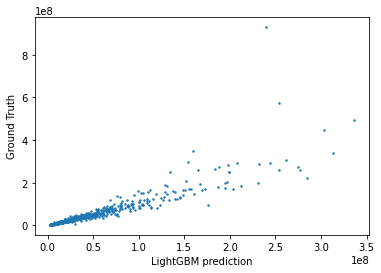

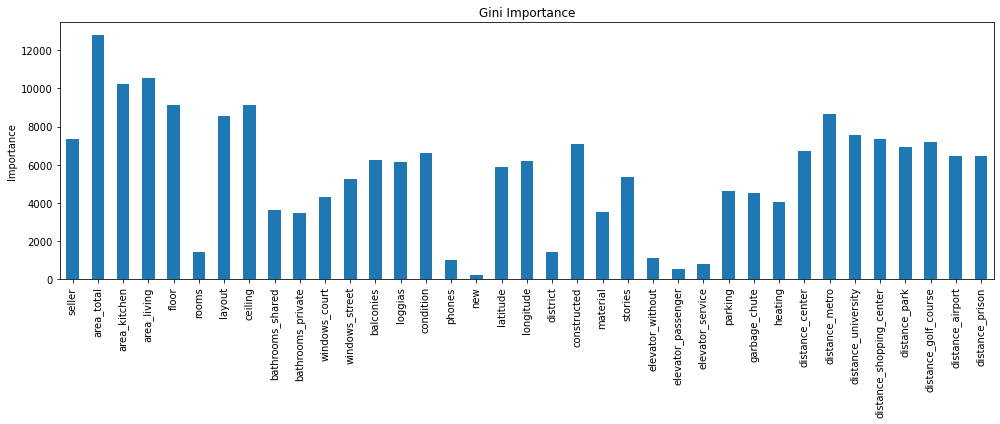

In [72]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=75,
    max_depth=10, 
    random_state=42,
    metric='rmse',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.7,
    subsample=0.9,
    learning_rate=0.03
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


lgbm_regressor.fit(X_train, y_train)

lgbm_prediction = lgbm_regressor.predict(X_test)
lgbm_prediction = np.exp(lgbm_prediction)

faulty_rows = []
for i in range(len(lgbm_prediction)):
    if lgbm_prediction[i] < 900000:
        lgbm_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

lgbm_rmsle = round(np.sqrt(mean_squared_log_error(lgbm_prediction, y_test)), 3)
print('Test RMSLE:', lgbm_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(lgbm_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(lgbm_prediction, y_test, s=2)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')
plt.show()

importances = lgbm_regressor.feature_importances_
forest_importances = pd.Series(importances, index=cols)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# 0.154 
# 0.139 log
# 0.131 log + all_features + rmsle
# 0.131 log + all_features + rmse
# 0.132 log + all_features-(prison, airport)
# 0.132 log + all_features + keep_high_prices

In [74]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
lgbm_predictions = lgbm_regressor.predict(test_data)
lgbm_predictions = np.exp(lgbm_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(lgbm_predictions)):
    if lgbm_predictions[i] < 900000:
        lgbm_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = lgbm_predictions
submission.to_csv("lgbm_predictions.csv", index=False)

# XGBoost

In [9]:
n_estimators=[100, 500, 900, 1100, 1500]
max_depth=[2, 3, 5, 10, 15]
booster=['gbtree', 'gblinear']
learning_rate=[0.025, 0.05, 0.1, 0.15, 0.20]
min_child_weight=[1, 2, 3, 4, 5]
base_score=[0.25, 0.5, 0.75, 1]


hyperparameter_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'booster':booster,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'base_score': base_score
    
}

<ipython-input-10-e421eb97c00f>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.13


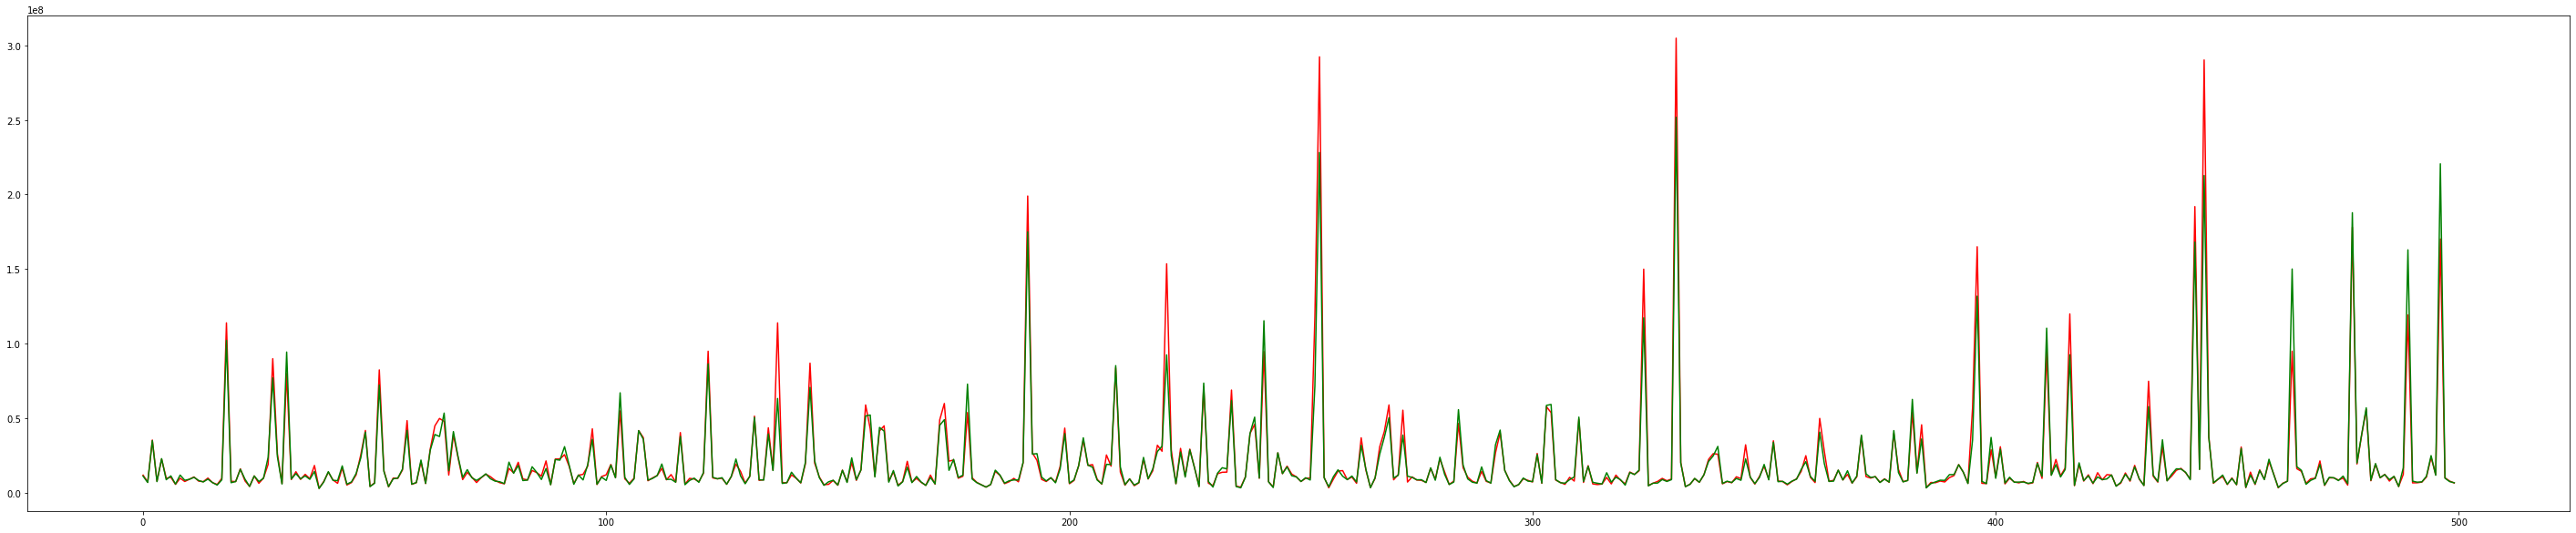

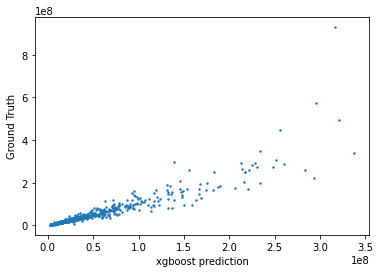

In [10]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# log prices
y_train = np.log(y_train)

scaler = preprocessing.StandardScaler().fit(X_train)

imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


"""
classifier=xgboost.XGBRegressor()

random_cv=RandomizedSearchCV(estimator=classifier, 
                             param_distributions=hyperparameter_grid, 
                             cv=5, 
                             scoring='neg_mean_absolute_error',
                             n_jobs=4,
                             verbose=5,
                             return_train_score=True,
                             random_state=42
                            )
random_cv.fit(X_train, y_train)
random_cv.best_estimator_
"""
xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None, objective='reg:squarederror')


xgboost_regressor.fit(X_train, y_train)

xgboost_prediction = xgboost_regressor.predict(X_test)
xgboost_prediction = np.exp(xgboost_prediction)


faulty_rows = []
for i in range(len(xgboost_prediction)):
    if xgboost_prediction[i] < 900000:
        xgboost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

xgboost_rmsle = round(np.sqrt(mean_squared_log_error(xgboost_prediction, y_test)), 3)
print('Test RMSLE:', xgboost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(xgboost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(xgboost_prediction, y_test, s=2)
plt.xlabel('xgboost prediction')
plt.ylabel('Ground Truth')
plt.show()

# 0.144
# 0.138 log
# 0.130 log + all_features
# 0.130 log + all_features + rmse


In [11]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
xgboost_predictions = xgboost_regressor.predict(test_data)
xgboost_predictions = np.exp(xgboost_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(xgboost_predictions)):
    if xgboost_predictions[i] < 900000:
        xgboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = xgboost_predictions
submission.to_csv("xgboost_predictions.csv", index=False)

 # Catboost

<ipython-input-35-be8e3af540fc>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.132


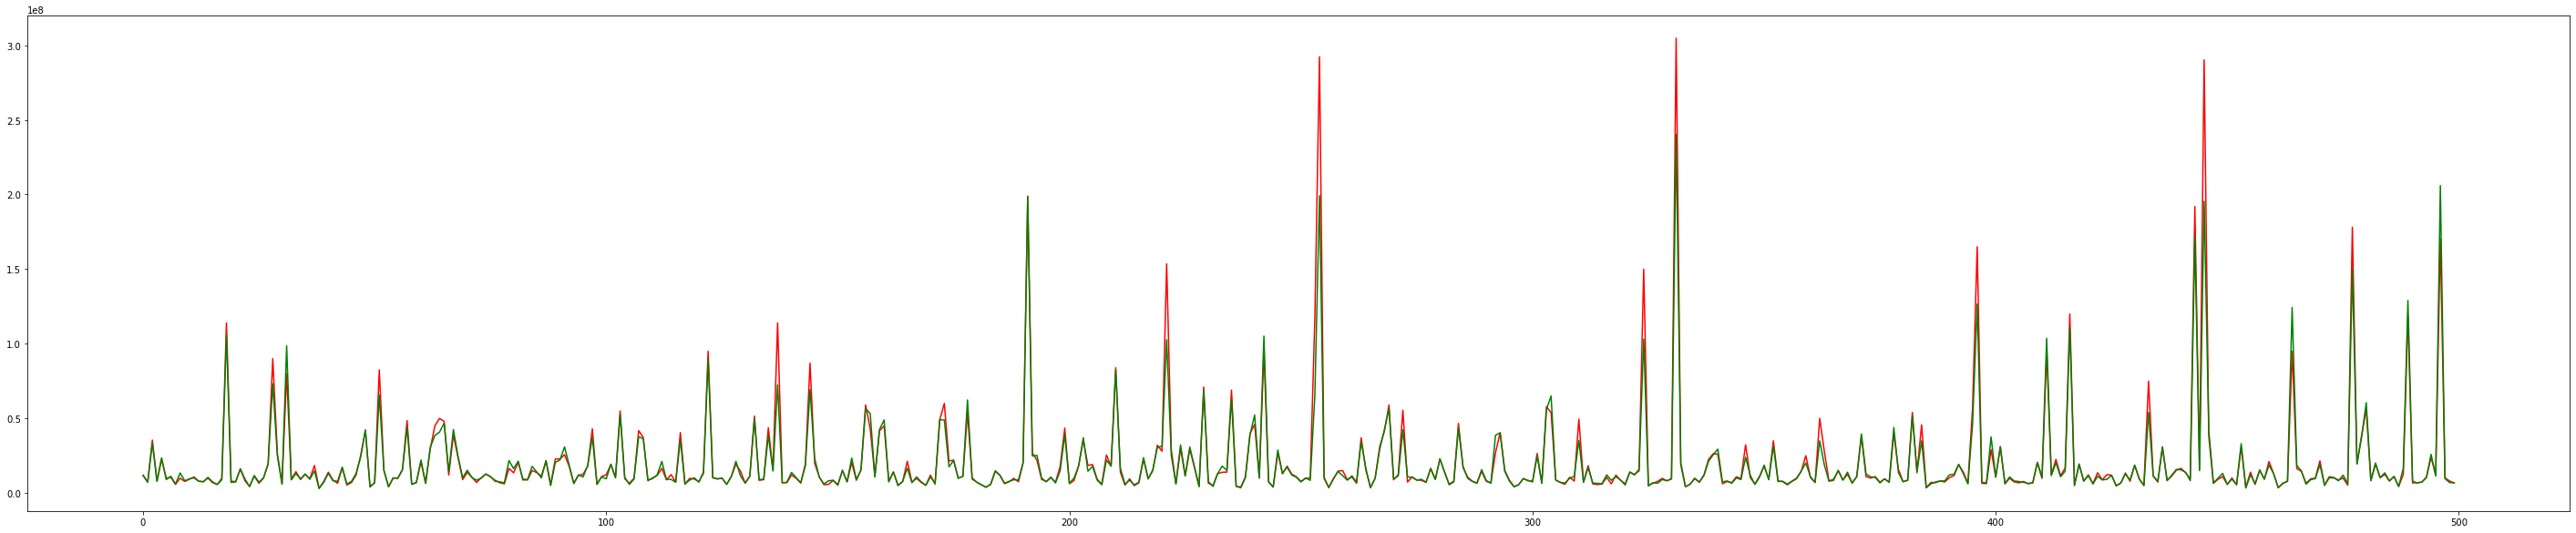

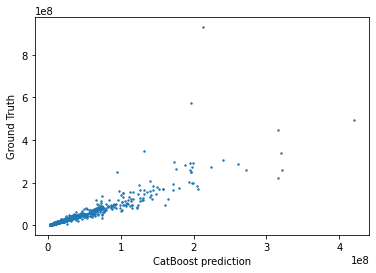

In [35]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

# log prices
y_train = np.log(y_train)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5
)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)



catboost_regressor = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    thread_count=-1,
    depth=10,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

#cat_features=['seller', 'condition', 'district','material','heating', 'parking']

catboost_regressor.fit(X_train, y_train)

cat_boost_prediction = catboost_regressor.predict(X_test)
cat_boost_prediction = np.exp(cat_boost_prediction)

faulty_rows = []
for i in range(len(cat_boost_prediction)):
    if cat_boost_prediction[i] < 900000:
        cat_boost_prediction[i] = 900000
        faulty_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

cat_boost_rmsle = round(np.sqrt(mean_squared_log_error(cat_boost_prediction, y_test)), 3)
print('Test RMSLE:', cat_boost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(cat_boost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(cat_boost_prediction, y_test, s=2)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')
plt.show()

# 0.170
# 0.142 log + all_features

In [36]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)

# predict
catboost_predictions = catboost_regressor.predict(test_data)
catboost_predictions = np.exp(catboost_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(catboost_predictions)):
    if catboost_predictions[i] < 900000:
        catboost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = catboost_predictions
submission.to_csv("catboost_predictions.csv", index=False)

# Random Forrest

<ipython-input-127-38d0b5cb5d61>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.146


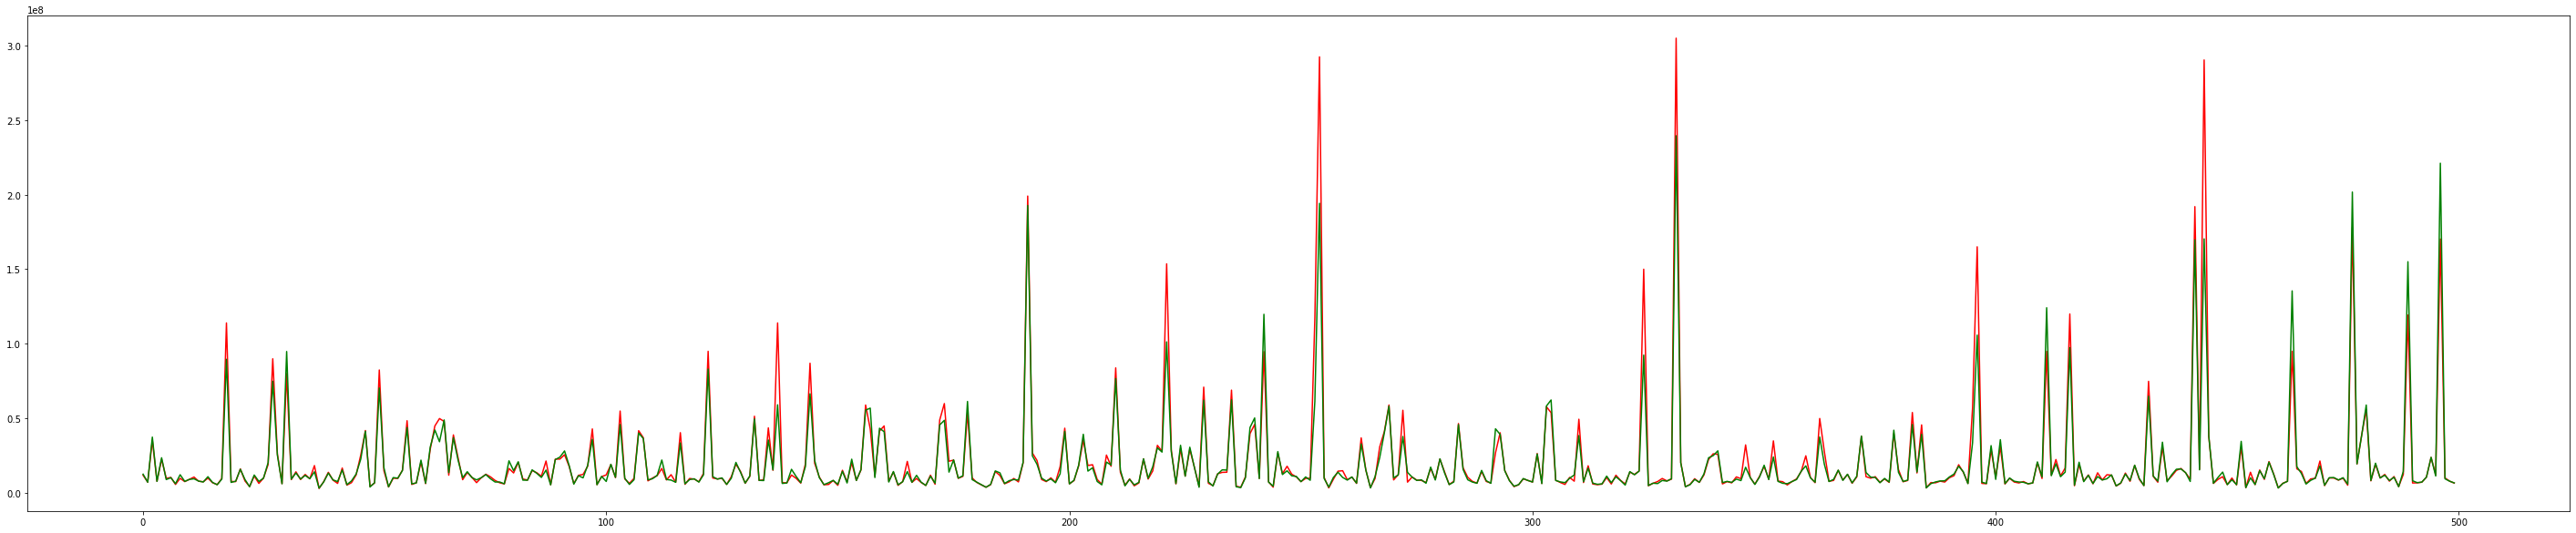

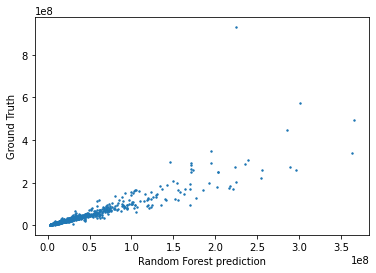

In [127]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

random_forest_regressor = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


random_forest_regressor.fit(X_train, y_train)

random_forest_prediction = random_forest_regressor.predict(X_test)
random_forest_prediction = np.exp(random_forest_prediction)

faulty_rows = []
for i in range(len(random_forest_prediction)):
    if random_forest_prediction[i] < 900000:
        random_forest_prediction[i] = 900000
        random_forest_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

random_forest_rmsle = round(np.sqrt(mean_squared_log_error(random_forest_prediction, y_test)), 3)
print('Test RMSLE:', random_forest_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(random_forest_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(random_forest_prediction, y_test, s=2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')
plt.show()

In [128]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
random_forest_predictions = random_forest_regressor.predict(test_data)
random_forest_predictions = np.exp(random_forest_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(random_forest_predictions)):
    if random_forest_predictions[i] < 900000:
        random_forest_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = random_forest_predictions
submission.to_csv("random_forest_predictions.csv", index=False)

# Ada Boosting

<ipython-input-131-aec6b4278672>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0
Test RMSLE: 0.304


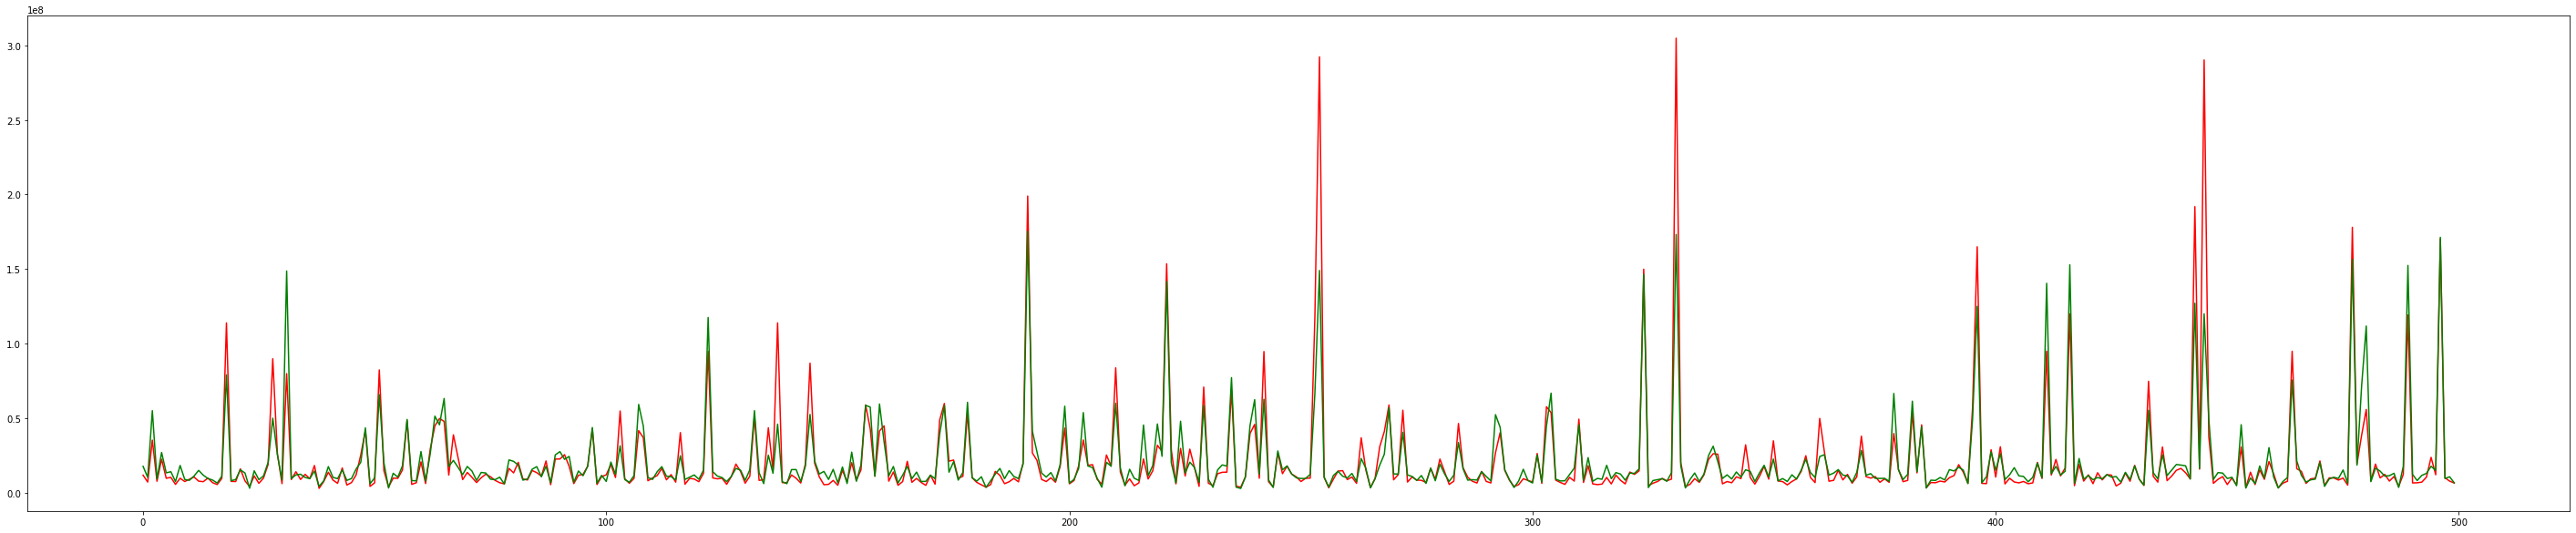

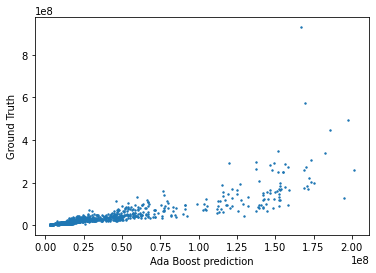

In [131]:
# normalize training data
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

cols = X_train.columns

# log prices
y_train = np.log(y_train)

ada_boost_regressor = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=42
)

scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)

X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)


ada_boost_regressor.fit(X_train, y_train)

ada_boost_prediction = ada_boost_regressor.predict(X_test)
ada_boost_prediction = np.exp(ada_boost_prediction)

faulty_rows = []
for i in range(len(ada_boost_prediction)):
    if ada_boost_prediction[i] < 900000:
        ada_boost_prediction[i] = 900000
        ada_boost_rows.append(X_test[i])

# list apartments resulting in too low price
print(len(faulty_rows))

ada_boost_rmsle = round(np.sqrt(mean_squared_log_error(ada_boost_prediction, y_test)), 3)
print('Test RMSLE:', ada_boost_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(ada_boost_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(ada_boost_prediction, y_test, s=2)
plt.xlabel('Ada Boost prediction')
plt.ylabel('Ground Truth')
plt.show()

In [132]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)


# predict
ada_boost_predictions = ada_boost_regressor.predict(test_data)
ada_boost_predictions = np.exp(ada_boost_predictions)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(ada_boost_predictions)):
    if ada_boost_predictions[i] < 900000:
        ada_boost_predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = ada_boost_predictions
submission.to_csv("ada_boost_predictions.csv", index=False)

# Stacking

In [134]:
acc = pd.DataFrame(
    {'LightGBM':     lgbm_rmsle,
     'XGBoost':      xgboost_rmsle,
     'CatBoost':     cat_boost_rmsle,
     'RandomForest': random_forest_rmsle,
     'AdaBoost': ada_boost_rmsle
    },
    index=[0]
)
acc = acc.T
acc.columns = ['MSE']
acc

,MSE
LightGBM,0.130
XGBoost,0.130
CatBoost,0.132
RandomForest,0.146
AdaBoost,0.304


# Simple averaging

Test MSE: 0.126


Text(0, 0.5, 'Ground Truth')

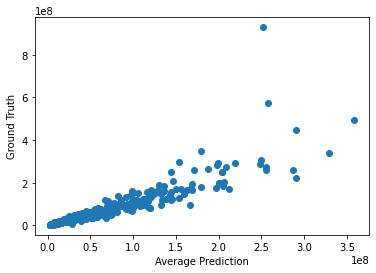

In [139]:
avg_prediction = np.average(
    [lgbm_prediction,
     xgboost_prediction,
     cat_boost_prediction,
     random_forest_prediction,
     ada_boost_prediction
     
    ],
    weights = 1 / acc['MSE'] ** 5,
    axis=0
)

print('Test MSE:', round(np.sqrt(mean_squared_log_error(avg_prediction, y_test)), 3))

plt.scatter(avg_prediction, y_test)
plt.xlabel('Average Prediction')
plt.ylabel('Ground Truth')

In [141]:
avg_predictions = np.average(
    [lgbm_predictions,
     xgboost_predictions,
     catboost_predictions,
     random_forest_predictions,
     ada_boost_predictions
    ],
    weights = 1 / acc['MSE'] ** 5,
    axis=0
)


In [142]:
# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  avg_predictions
submission.to_csv("average_predictions.csv", index=False)

# True Stacking

### First Step

In [143]:
train_data = dfTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.10, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])


scaler = preprocessing.StandardScaler().fit(X_train)
imputor=IterativeImputer(
    estimator=BayesianRidge(),
    imputation_order='ascending', 
    max_iter=100,
    tol=1e-5)


X_train = imputor.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = imputor.fit_transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)



<ipython-input-143-ed88c09e46e1>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]
C:\Users\levit\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [144]:
# normalize columns test data
test_data = dfTest.copy()
test_data = process_data(test_data, keep_col=['id_x', 'price'])

# separate id from test data
ids = test_data.pop("id_x")

test_data = imputor.fit_transform(test_data)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(test_data)

In [145]:
def add_distance_to(target, df_train, df_test):
    targets = pd.read_csv(f"prepared_data/extra_features/{target}.csv")
    coordinates = targets.values.tolist()

    df_train[f"distance_{target}"] = df_train.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)
    df_test[f"distance_{target}"] = df_test.loc[:, "latitude":"longitude"].apply(lambda x: get_shortest_distance(x.latitude, x.longitude, coordinates), axis=1)

""" positive """
add_distance_to("metro", dfTrain, dfTest)
add_distance_to("university", dfTrain, dfTest)
add_distance_to("shopping_center", dfTrain, dfTest)
add_distance_to("park", dfTrain, dfTest)
add_distance_to("golf_course", dfTrain, dfTest)
""" negative """
add_distance_to("airport", dfTrain, dfTest)
add_distance_to("prison", dfTrain, dfTest)

In [146]:
ntrain = X_train.shape[0]
ntest = test_data.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [147]:
lgbm_regressor = lgb.LGBMRegressor(
    num_leaves=100,
    max_depth=10, 
    random_state=42,
    metric='rmsle',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

xgboost_regressor=xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=4,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


catboost_regressor = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    thread_count=-1,
    depth=10,
    silent=True,
    random_state=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

random_forest_regressor = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

ada_boost_regressor = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=42
)


In [148]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.ravel()

dt_oof_train, dt_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
print('All preictions for train set:', len(dt_oof_train))
print('All preictions for test set:', len(dt_oof_test))

All preictions for train set: 20935
All preictions for test set: 9937


In [149]:
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_regressor, X_train, y_train, test_data)
xgb_oof_train, xgb_oof_test = get_oof(xgboost_regressor, X_train, y_train, test_data)
cat_oof_train, cat_oof_test = get_oof(catboost_regressor, X_train, y_train, test_data)
rf_oof_train, rf_oof_test = get_oof(random_forest_regressor, X_train, y_train, test_data)
ad_oof_train, ad_oof_test = get_oof(ada_boost_regressor, X_train, y_train, test_data)

### Second Step

In [150]:
x_train = np.concatenate((
    lgbm_oof_train,
    xgb_oof_train,
    cat_oof_train,
    rf_oof_train,
    ad_oof_train
), axis=1)

x_test = np.concatenate((
    lgbm_oof_test,
    xgb_oof_test,
    cat_oof_test,
    rf_oof_test,
    ad_oof_test
), axis=1)

In [151]:
META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=200,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.05
)

META_MODEL.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=7, metric='mse',
              n_estimators=200, n_jobs=4, num_leaves=5, random_state=42,
              subsample=0.9)

In [152]:
final_predictions = META_MODEL.predict(x_test)

In [153]:
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] =  final_predictions
submission.to_csv("final_predictions.csv", index=False)